# Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch, then use it to recognize digits on the MNIST dataset

In [61]:
import math
import numpy as np
import matplotlib.pyplot as plt

from time import time, sleep
from datetime import datetime
from IPython import display

%matplotlib inline

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [62]:
# load your modules
%run Modules.ipynb

Optimizer is implemented for you. 

In [63]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1
            
# batch generator
def get_batches( (X, Y) , batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

# helper train function
def do_train(XX, YY, net, net_criterion):
    st = datetime.now()
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches( (XX, YY) , batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = net_criterion.forward(predictions, y_batch)

            # Backward
            dp = net_criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(14, 10))

        plt.title("Training loss, epoch {}/{}".format(str(i+1), str(n_epoch)))
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss)
        
    print str(n_epoch), 'epochs trained for', datetime.now() - st
        
    return loss_history

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

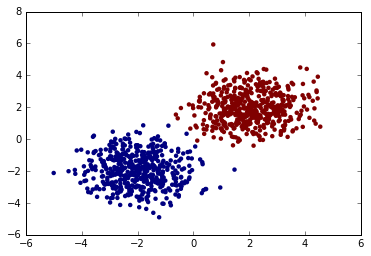

In [64]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Ytoy = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Ytoy = np.hstack([Ytoy, 1-Ytoy])

Xtoy = np.vstack([X1,X2])
plt.scatter(Xtoy[:,0],Xtoy[:,1], c = Ytoy[:,0], edgecolors= 'none')

### Once you are done with Linear and Softmax modules, try to run this **logistic regression**  architecture

In [65]:
# define architecture
criterion = MSECriterion()
LRnet = Sequential()       
LRnet.add(Linear(2, 2))    # implement Modules.Linear
LRnet.add(SoftMax())       # implement Modules.Softmax
print LRnet

# define optimization parameters
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
n_epoch = 10
batch_size = 128

Linear 2 -> 2
SoftMax



### Correct output will be visible until you run the cell

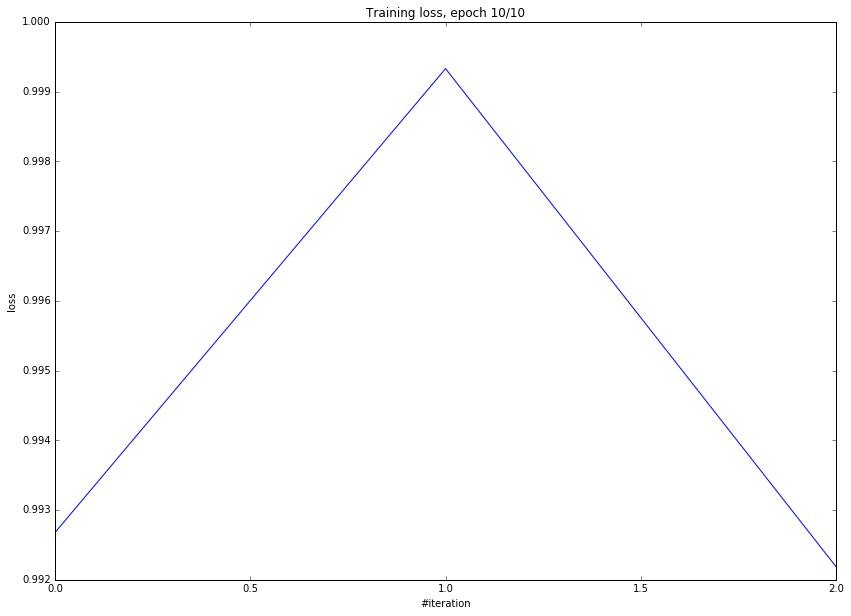

Current loss: nan
10 epochs trained for 0:00:04.511097


In [66]:
_ = do_train(Xtoy, Ytoy, LRnet, criterion)

In [67]:
# Use this function to measure the accuracy of your models
def evaluate(network, test_data, test_labels):
    """
    Uses one-hot encoded labeled data to evaluate a given model
    """
    
    predictions = network.forward(test_data)
    correct = sum(np.argmax(predictions, axis=1) == np.argmax(test_labels, axis=1))
    cor_frac = correct/float(test_data.shape[0])
    print("Model accuracy = {} %".format(cor_frac*100))
    return cor_frac

In [68]:
acc = evaluate(LRnet, Xtoy, Ytoy)

Model accuracy = 50.0 %


# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/).

### **Download** the MNIST dataset

In [48]:
import os
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split

# Fetch MNIST dataset and create a local copy.
# This might take a minute or two...

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

KeyboardInterrupt: 

### One-hot encode the labels first.

In [11]:
"""
Your code goes here
"""
Y_ENC = np.zeros((len(y), len(set(y))))
for i, yi in enumerate(y):
    Y_ENC [i][int(yi)] = 1

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y_ENC, test_size=0.25, random_state=42)

In [12]:
print Xtrain.shape, Ytrain.shape # Should be like this

(52500, 784) (52500, 10)


## Science time!

- Compare **`ReLU`, `ELU`** and **`LeakyReLU`** activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- Plot the losses from all tested architectures on one plot. You may use the provided code.
- Hint: logloss for MNIST should be well below 0.5. 

In [13]:
# define optimization parameters
optimizer_config = {'learning_rate' : 2e-1, 'momentum': 0.5}
optimizer_state = {}
n_epoch = 10
batch_size = 128

In [ ]:
# define architecture with ReLU activation
criterion = ClassNLLCriterion() # You gonna need multiclass criterion for this one
net0 = Sequential()
"""
Your code goes here
"""
print net0

optimizer_state = {}
net0_loss = do_train(Xtrain, Ytrain, net0, criterion)

In [ ]:
acc = evaluate(net0, Xtest, Ytest)

In [ ]:
# define architecture with ELU activation
criterion = ClassNLLCriterion()
net1 = Sequential()
"""
Your code goes here
"""
print net1

optimizer_state = {}
net1_loss = do_train(Xtrain, Ytrain, net1, criterion)

In [ ]:
acc = evaluate(net1, Xtest, Ytest)

In [ ]:
# define architecture with LeakyReLU activation
criterion = ClassNLLCriterion()
net2 = Sequential()
"""
Your code goes here
"""
print net2

optimizer_state = {}
net2_loss = do_train(Xtrain, Ytrain, net2, criterion)

In [ ]:
acc = evaluate(net2, Xtest, Ytest)

In [ ]:
# plot all losses on  a single graph
names = ['ReLU','ELU', 'LeakyReLU']
rezs = [net0_loss, net1_loss, net2_loss]

plt.figure(figsize=(14, 10))
for i, n in enumerate(names):
    plt.plot(range(len(rezs[i])),rezs[i], label=n)
    
plt.legend(loc='best',prop={'size':16})
plt.xlabel('log_iterations')
plt.ylabel('loss')
plt.title('Comparison of activation functions')
plt.xscale('log')

plt.show()

Write your personal opinion on the activation functions, think about computation times too.

Finally, use all the knowledge you've gained to build a ***super-cool*** model to reach maximum accuracy of MNIST dataset. See if you can get below 2% error. You may want to use modules from the bonus section. Good luck!